# Are the SNe in DC2 found by the DRP pipeline?

### Load the butler for the DC2 processing and get the DC2 SN truth catalogs:

In [2]:
from lsst.daf.butler import Butler
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from lsst.ap.association import UnpackApdbFlags, TransformDiaSourceCatalogConfig
import pandas as pd
import pyarrow.parquet as pq

In [4]:
from astropy.coordinates import SkyCoord
import astropy.units as u
import lsst.geom
from astropy.time import Time

In [5]:
butler = Butler('/repo/dc2', collections="2.2i/runs/test-med-1/w_2021_24/DM-30674")

In [6]:
snTruth = pq.read_table('/home/csaunder/stack_projects/DC2_supernovae/sn_truth_summary.parquet').to_pandas()
snTruth_lcs = pq.read_table('/home/csaunder/stack_projects/DC2_supernovae/sn_variability_truth.parquet').to_pandas()

### Get the DC2 tract information:

In [7]:
skymap = butler.get("skyMap")
tractInfo = skymap.generateTract(3828)
tractWcs = tractInfo.getWcs()

### Get the SNe from the truth catalog that are in the Tract 3828 footprint:

In [8]:
sn_sps = np.array([lsst.geom.SpherePoint(sn['ra'], sn['dec'], lsst.geom.degrees) for s, sn in snTruth.iterrows()])
sn_3828 = np.array([tractInfo.contains(lsst.geom.SpherePoint(sn['ra'], sn['dec'], lsst.geom.degrees)) for s, sn in snTruth.iterrows()])
sn_in3828 = snTruth[sn_3828]

In [9]:
sn_pixels = tractWcs.skyToPixelArray(sn_in3828['ra'], sn_in3828['dec'], degrees=True)

### Set up function to determine which SN lightcurve points should be in a given difference image and whether they are detected:

In [17]:
def find_detected_points(visit_list, band, max_visits=30):
    visit_points = []
    detected_points = []
    for vis in visit_list[:max_visits]:
        diffRefs = list(set(butler.registry.queryDatasets('goodSeeingDiff_differenceExp', dataId={'visit': vis})))
        print(vis, len(diffRefs))

        sample = butler.get(diffRefs[0])
        date = sample.getInfo().getVisitInfo().getDate()
        mjd = date.get(date.MJD)
        lc_points = snTruth_lcs[(snTruth_lcs['bandpass'] == diffRefs[0].dataId['band'])
                                & (abs(snTruth_lcs['MJD'] - mjd) < 0.0005)]
        # & (snTruth_lcs['MJD'] == mjd_match)]
        print(mjd, np.unique(lc_points['MJD']))
        point_check = 0
        print(mjd, len(lc_points))
        membership = sn_in3828['id'].isin(lc_points['id'])
        vis_sne = sn_in3828[membership]
        print(len(vis_sne), 'in this visit in 3828')
        if len(vis_sne) == 0:
            print(len(lc_points))
            continue
        vis_x = sn_pixels[0][membership]
        vis_y = sn_pixels[1][membership]
        sne_cat = SkyCoord(vis_sne['ra'], vis_sne['dec'], unit=u.degree)
        # CHeck whether sn point is in diffIm, then whether it matches any detections
        plt.figure()
        plt.scatter(vis_sne['ra'], vis_sne['dec'], label='All SN points')
        print(f'Scanning {len(diffRefs)} images:')
        for diffRef in list(diffRefs):
            diffIm = butler.get('goodSeeingDiff_differenceExp', dataId=diffRef.dataId)
            diaSrc = butler.get('goodSeeingDiff_diaSrc', dataId=diffRef.dataId)
            diffIm_bbox = diffIm.getBBox()
            diffWcs = diffIm.getWcs()

            # Plot the image edges:
            xCorners = [diffIm_bbox.minX, diffIm_bbox.maxX, diffIm_bbox.maxX, diffIm_bbox.minX]
            yCorners = [diffIm_bbox.minY, diffIm_bbox.minY, diffIm_bbox.maxY, diffIm_bbox.maxY]
            raDecSPs = [diffWcs.pixelToSky(x, y) for (x, y) in zip(xCorners, yCorners)]
            raDecCorners = np.array([[sp.getRa().asDegrees(), sp.getDec().asDegrees()] for sp in raDecSPs])
            centerSP = diffWcs.pixelToSky(diffIm_bbox.centerX, diffIm_bbox.centerY)
            plt.plot(raDecCorners[:,0], raDecCorners[:,1])
            plt.text(centerSP.getRa().asDegrees(), centerSP.getDec().asDegrees(), diffRef.dataId['detector'])

            # Find SNe that should be in this image:
            det_x, det_y = diffWcs.skyToPixelArray(vis_sne['ra'], vis_sne['dec'], degrees=True)
            diffIm_sne = np.array([diffIm_bbox.contains(x, y) for (x, y) in zip(det_x, det_y)])

            # If there are any SNe, see if they are detected:
            if diffIm_sne.sum() > 0:
                diffIm_lc_points = lc_points[lc_points['id'].isin(vis_sne[diffIm_sne]['id'])]
                point_detects = np.zeros(len(diffIm_lc_points), dtype=bool)
                diaCat = SkyCoord(diaSrc['coord_ra'], diaSrc['coord_dec'], unit=u.radian)

                if (len(diaCat) == 0) or (len(sne_cat[diffIm_sne]) == 0): continue
                idx, d2d, d3d = sne_cat[diffIm_sne].match_to_catalog_sky(diaCat)
                print(f'Matched {(d2d.arcsecond < 1).sum()} out of {diffIm_sne.sum()} SNe in image')
                match_sne = vis_sne[diffIm_sne][d2d.arcsecond < 1]
                plt.scatter(match_sne['ra'], match_sne['dec'],
                            label=('Detected point' if point_check == 0 else None))
                match_membership = diffIm_lc_points['id'].isin(match_sne['id'])
                if len(match_sne) > 0:
                    print('Points matched:')
                    print(diffIm_lc_points[match_membership])
                point_check += len(match_sne)
                point_detects[match_membership] = True
                visit_points.append(diffIm_lc_points)
                detected_points.append(point_detects)
        plt.legend()
        plt.show()
    return visit_points, detected_points

## Compare truth catalogs with the DIA sources that are actually detected:

## R band:

In [11]:
diaSrcsR = list(set(butler.registry.queryDatasets('goodSeeingDiff_diaSrc', dataId={"band": "r", "skymap": 'DC2', "tract": 3828})))
print(f"found {len(diaSrcsR)} diaSrcs in HSC-R")
rVisits = list(set(diaSrcR.dataId['visit'] for diaSrcR in diaSrcsR))
print(len(rVisits))
print(rVisits)

found 1082 diaSrcs in HSC-R
60
[202627, 202628, 212739, 252422, 257797, 252424, 213513, 213514, 162699, 456716, 436492, 436491, 451452, 212118, 212119, 414873, 236833, 451489, 193189, 242597, 213545, 451502, 219950, 415029, 193848, 436538, 416955, 448317, 212805, 212806, 398407, 479434, 452556, 452557, 398413, 401616, 193233, 193232, 193235, 252377, 300250, 202587, 300252, 202590, 193888, 212704, 271328, 271331, 199651, 212071, 257768, 440938, 456690, 236788, 212085, 467701, 193144, 202617, 193147, 401660]


202627 6
59854.29908922338 [59854.298742 59854.299213]
59854.29908922338 1071
41 in this visit in 3828
Scanning 6 images:
Matched 1 out of 3 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
43636831  MS_9683_1933     202627  59854.298742        r  1553.185181
43636832  MS_9683_1933     202628  59854.299213        r  1553.159058
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image


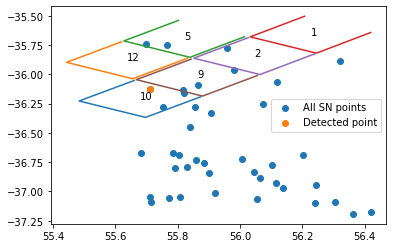

202628 9
59854.299560221065 [59854.299213 59854.299745]
59854.299560221065 684
34 in this visit in 3828
Scanning 9 images:
Matched 2 out of 7 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18731895  MS_9812_207     202628  59854.299213        r  2140.030273
19907040  MS_9812_846     202628  59854.299213        r  2669.902344
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass    delta_flux
18387544  MS_9812_17     202628  59854.299213        r  14863.842773
Matched 0 out of 5 SNe in image
Matched 0 out of 5 SNe in image


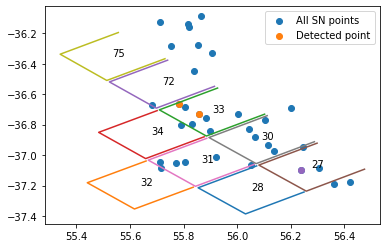

212739 41
59868.14524922338 [59868.144902 59868.145351]
59868.14524922338 1093
72 in this visit in 3828
Scanning 41 images:
Matched 1 out of 3 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass   delta_flux
18387571  MS_9812_17     212739  59868.144902        r  7963.575195
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 7 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass   delta_flux
18494731  MS_9812_82     212739  59868.144902        r  2129.650879
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image


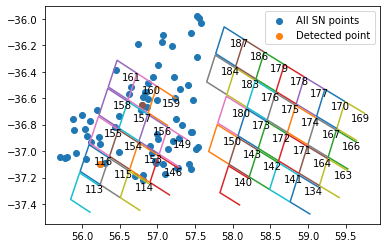

252422 48
59929.14748622454 [59929.147139 59929.147615]
59929.14748622454 752
104 in this visit in 3828
Scanning 48 images:
Matched 0 out of 3 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
41235208  MS_9683_757     252422  59929.147139        r  1968.817261
Matched 1 out of 2 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass  delta_flux
19351032  MS_9812_534     252422  59929.147139        r  4115.58252
Matched 0 out of 1 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
19482436  MS_9812_606     252422  59929.147139        r  3551.749512
Matched 1 out of 4 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
30188137  MS_9684_918     252422  59929.147139        r  1232.288452
Matched 0 out of 2 SNe in image
Matched 1 out of 2 SNe in image
Points

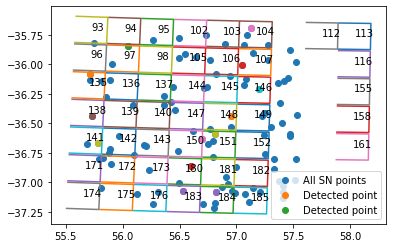

257797 1
59937.12032821991 [59937.119981 59937.120482]
59937.12032821991 1122
2 in this visit in 3828
Scanning 1 images:


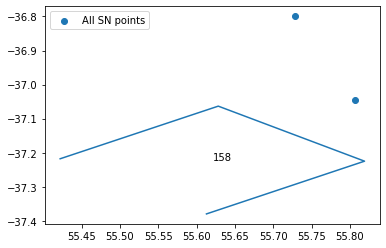

252424 6
59929.14844622454 [59929.148099]
59929.14844622454 559
14 in this visit in 3828
Scanning 6 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass  delta_flux
31897225  MS_9684_1892     252424  59929.148099        r  721.444092


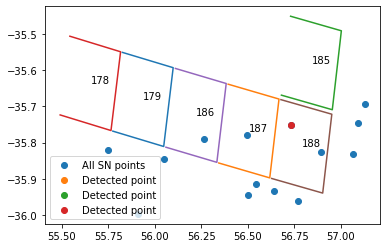

213513 32
59869.14335222222 [59869.143005 59869.143451]
59869.14335222222 1106
84 in this visit in 3828
Scanning 32 images:
Matched 0 out of 3 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 4 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass  delta_flux
32158876  MS_9684_2034     213513  59869.143005        r  909.645691
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 5 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
19642999  MS_9812_696     213513  59869.143005        r  3160.799805
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 5 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass  delta_flux
22361020  MS_9812_2149     213513  59869.143005        r  539.778381
Matched 0 out of 1 SNe in imag

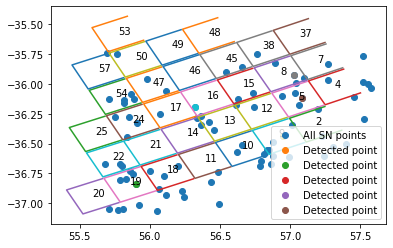

213514 13
59869.14379821991 [59869.143451 59869.143898]
59869.14379821991 1139
11 in this visit in 3828
Scanning 13 images:
Matched 0 out of 1 SNe in image


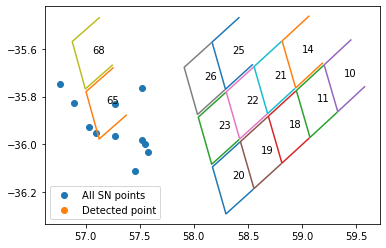

162699 29
59798.315562222226 [59798.315215 59798.315664]
59798.315562222226 1145
92 in this visit in 3828
Scanning 29 images:
Matched 0 out of 2 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18673098  MS_9812_174     162699  59798.315215        r  5265.735352
Matched 1 out of 2 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
19048597  MS_9812_374     162699  59798.315215        r  1273.204834
Matched 1 out of 3 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass   delta_flux
28688461  MS_9684_17     162699  59798.315215        r  3242.734863
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 5 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass    delta_flux
28828256

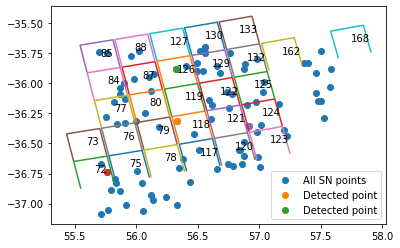

456716 67
60240.14578622454 [60240.145439 60240.145888]
60240.14578622454 1056
99 in this visit in 3828
Scanning 67 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
19219386  MS_9812_463     456716  60240.145439        r  1682.400513
Matched 1 out of 5 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass   delta_flux
18401509  MS_9812_25     456716  60240.145439        r  9938.765625
18401510  MS_9812_25     456717  60240.145888        r  9938.563477
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 4 SNe in image
Points matched:
                   id  obsHistID      

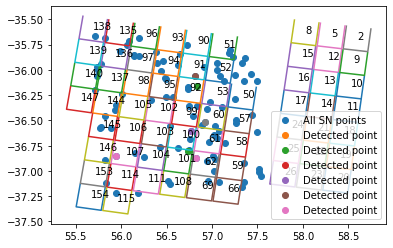

436492 16
60206.2625932199 [60206.262246 60206.262695]
60206.2625932199 1203
39 in this visit in 3828
Scanning 16 images:
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
21181435  MS_9812_1526     436492  60206.262246        r  1164.158447
Matched 0 out of 2 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18746296  MS_9812_217     436492  60206.262246        r  7825.080078
Matched 1 out of 1 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass  delta_flux
21585307  MS_9812_1737     436492  60206.262246        r   690.38092
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image


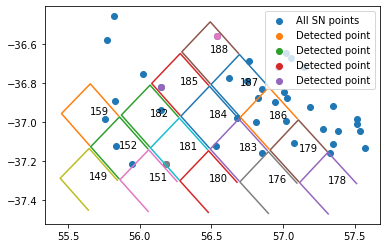

436491 12
60206.26214422338 [60206.261797 60206.262246]
60206.26214422338 1172
49 in this visit in 3828
Scanning 12 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass  delta_flux
21585306  MS_9812_1737     436491  60206.261797        r  690.349487
21585307  MS_9812_1737     436492  60206.262246        r  690.380920
Matched 0 out of 2 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
21181434  MS_9812_1526     436491  60206.261797        r  1164.174683
21181435  MS_9812_1526     436492  60206.262246        r  1164.158447


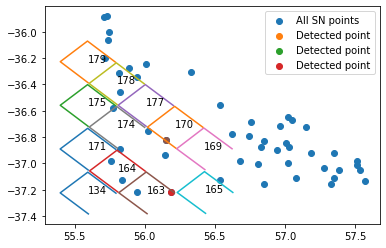

451452 2
60232.13117422338 [60232.130827 60232.131274]
60232.13117422338 1160
3 in this visit in 3828
Scanning 2 images:


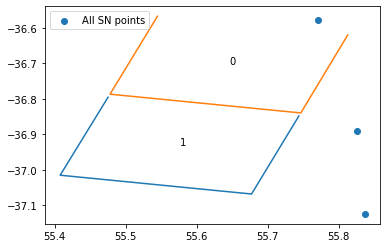

212118 49
59867.238957222224 [59867.23861  59867.239059]
59867.238957222224 1062
81 in this visit in 3828
Scanning 49 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image


KeyboardInterrupt: 

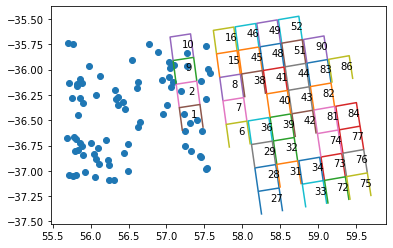

In [18]:
r_visit_points, r_detected_points = find_detected_points(rVisits, 'r')

In [224]:
allR_visit_points = pd.concat(r_visit_points)
allR_detected_points = np.concatenate(r_detected_points)
print(len(allR_visit_points), len(allR_detected_points))

704 704


### Which points are detected?

Text(0.5, 0, 'delta_flux')

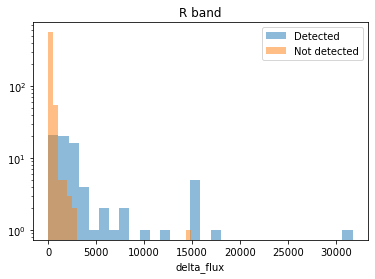

In [225]:
plt.hist(allR_visit_points['delta_flux'][allR_detected_points], alpha=0.5, bins=30, log=True, label='Detected');
plt.hist(allR_visit_points['delta_flux'][~allR_detected_points], alpha=0.5, bins=30, log=True, label='Not detected');
plt.legend()
plt.title('R band')
plt.xlabel('delta_flux')

## I band:

In [204]:
diaSrcsI = list(set(butler.registry.queryDatasets('goodSeeingDiff_diaSrc', dataId={"band": "i", "skymap": 'DC2', "tract": 3828})))
print(f"found {len(diaSrcsI)} diaSrcs in HSC-I")
iVisits = list(set(diaSrcI.dataId['visit'] for diaSrcI in diaSrcsI))
print(len(iVisits))
print(iVisits)

found 1661 diaSrcs in HSC-I
75
[479620, 248966, 227976, 397322, 248970, 227984, 397330, 397331, 211477, 457749, 491550, 280217, 427674, 211099, 211484, 263453, 211100, 263455, 471963, 263452, 211490, 214434, 204706, 244004, 244005, 204708, 433960, 214433, 433962, 421682, 471987, 228020, 244028, 244029, 211132, 496959, 496960, 214465, 214464, 214467, 211140, 211141, 174534, 211527, 433992, 177481, 211530, 433993, 211531, 263501, 263502, 211533, 428492, 457681, 280271, 230740, 211228, 211483, 211545, 496989, 397278, 397279, 421725, 192355, 244068, 428525, 227950, 227951, 472179, 410996, 457721, 457723, 228092, 211198, 256383]


479620 65
60279.226956224535 [60279.226609 60279.227089]
60279.226956224535 1161
103 in this visit in 3828
Scanning 65 images:
Matched 1 out of 1 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
21204229  MS_9812_1539     479620  60279.226609        i  2057.044189
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 7 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 3 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
29424892  MS_9684_452     479620  60279.226609        i  2578.091797
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 

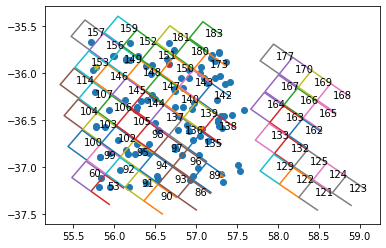

248966 11
59923.16401321991 [59923.163666 59923.164116]
59923.16401321991 1063
30 in this visit in 3828
Scanning 11 images:
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 4 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass  delta_flux
19351029  MS_9812_534     248966  59923.163666        i  2034.50769
Matched 0 out of 3 SNe in image


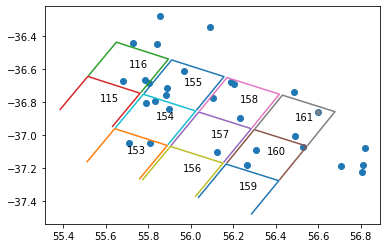

227976 73
59887.21648122453 [59887.216134 59887.216601]
59887.21648122453 1111
89 in this visit in 3828
Scanning 73 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
22438338  MS_9812_2191     227976  59887.216134        i  1465.084961
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 3 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
20713847  MS_9812_1279     227976  59887.216134        i  1398.298218
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 S

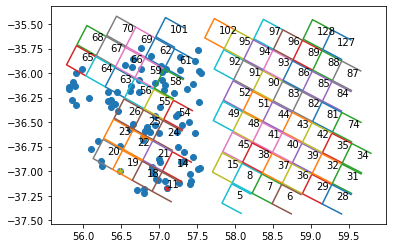

397322 27
60142.39769122454 [60142.397344 60142.39779 ]
60142.39769122454 1145
101 in this visit in 3828
Scanning 27 images:
Matched 0 out of 3 SNe in image
Matched 1 out of 3 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass  delta_flux
18607747  MS_9812_144     397322  60142.397344        i  2765.12500
18607748  MS_9812_144     397323  60142.397790        i  2765.07373
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 1 out of 6 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
41504646  MS_9683_889     397322  60142.397344        i  1594.113892
41504647  MS_9683_889     397323  60142.397790        i  1594.088379
Matched 0 out of 3 SNe in image
Matched 2 out of 3 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass  delta_flux
18457576   MS_9812_62     397322  60142.397344        i  2863.02002
19080299  MS_9812_389   

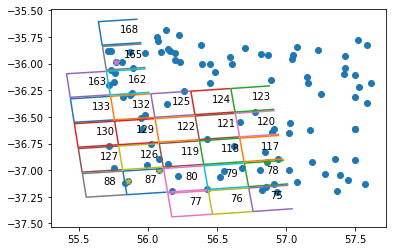

248970 41
59923.16582922338 [59923.165482 59923.165943]
59923.16582922338 919
54 in this visit in 3828
Scanning 41 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 2 out of 6 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18494761   MS_9812_82     248970  59923.165482        i  3908.715576
18545002  MS_9812_111     248970  59923.165482        i  1830.015747


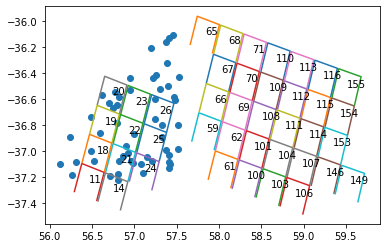

227984 82
59887.220263219904 [59887.219916 59887.220367]
59887.220263219904 1101
109 in this visit in 3828
Scanning 82 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 7 SNe in image
Matched 0 out of 6 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass  delta_flux
18536618  MS_9812_104     227984  59887.219916        i  6097.19043
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 

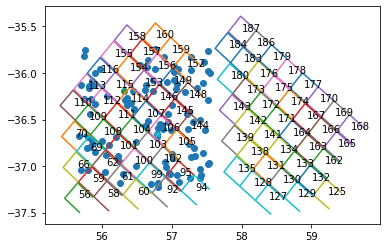

397330 20
60142.401451224534 [60142.401104 60142.40155 ]
60142.401451224534 1125
68 in this visit in 3828
Scanning 20 images:
Matched 1 out of 1 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass  delta_flux
21473261  MS_9812_1681     397330  60142.401104        i  972.003235
Matched 1 out of 4 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass  delta_flux
18457577  MS_9812_62     397330  60142.401104        i  2862.47876
Matched 0 out of 1 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
19080300  MS_9812_389     397330  60142.401104        i  3603.714355
Matched 1 out of 3 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
42991782  MS_9683_1617     397330  60142.401104        i  1718.297729
42991783  MS_9683_1617     397331  60142.401550        i  1718.289429
Matched 0 out of 4 SNe in imag

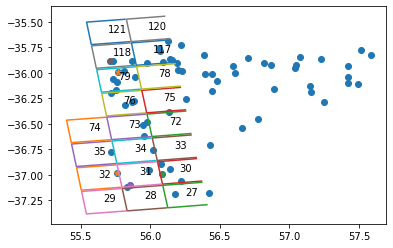

397331 22
60142.401897222226 [60142.40155  60142.401999]
60142.401897222226 1110
58 in this visit in 3828
Scanning 22 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID          MJD bandpass   delta_flux
19313388  MS_9812_513     397331  60142.40155        i  3932.127441
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 4 SNe in image
Points matched:
                    id  obsHistID          MJD bandpass   delta_flux
42991783  MS_9683_1617     397331  60142.40155        i  1718.289429
Matched 0 out of 3 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 3 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
        

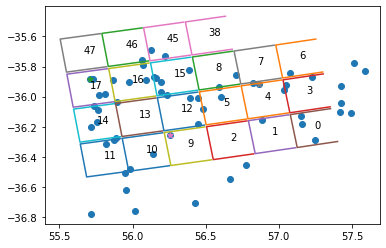

211477 13
59866.32105821991 [59866.320711 59866.321167]
59866.32105821991 1105
41 in this visit in 3828
Scanning 13 images:
Matched 0 out of 6 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 3 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
19907060  MS_9812_846     211477  59866.320711        i  2317.279053
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass    delta_flux
18536596  MS_9812_104     211477  59866.320711        i  11920.985352
Matched 0 out of 1 SNe in image


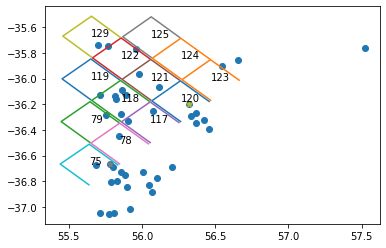

457749 22
60241.25129821991 [60241.250951 60241.251418]
60241.25129821991 848
53 in this visit in 3828
Scanning 22 images:
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 1 out of 6 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass    delta_flux
18401517  MS_9812_25     457749  60241.250951        i  11752.460938
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 1 out of 3 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
20158991  MS_9812_982     457749  60241.250951        i  3009.510498
Matched 1 out of 2 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass  delta_flux
21585325  MS_9812_1737     457749  60241.250951        i  812.389282
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 2 out of 3 SNe in image
Points matched:
               

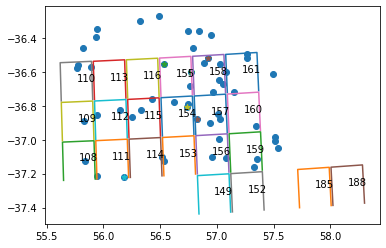

491550 1
60301.20739522106 [60301.207048 60301.207497]
60301.20739522106 1088
7 in this visit in 3828
Scanning 1 images:


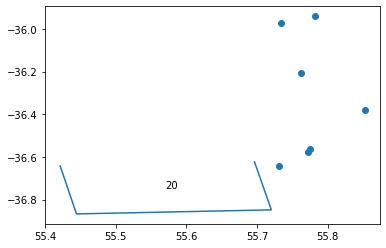

280217 91
59975.138836224534 [59975.138489 59975.138938]
59975.138836224534 1083
120 in this visit in 3828
Scanning 91 images:
Matched 0 out of 4 SNe in image
Matched 1 out of 3 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18545020  MS_9812_111     280217  59975.138489        i  1763.261475
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18970763  MS_9812_334     280217  59975.138489        i  4405.429199
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 1 out of 4 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass  delta_flux
34209245  MS_9684_3181     280217  59975.138489        i  901.749451
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in i

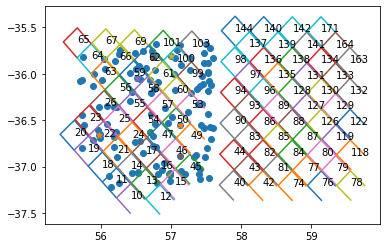

427674 6
60192.36275522107 [60192.362408 60192.362874]
60192.36275522107 1152
13 in this visit in 3828
Scanning 6 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image


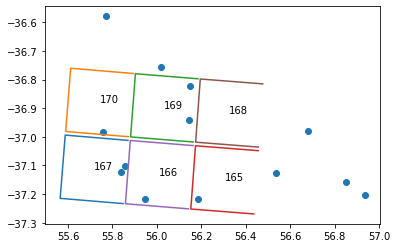

211099 96
59866.14347022107 [59866.143123 59866.14357 ]
59866.14347022107 1070
114 in this visit in 3828
Scanning 96 images:
Matched 1 out of 4 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass  delta_flux
18494721  MS_9812_82     211099  59866.143123        i  940.717102
Matched 0 out of 1 SNe in image
Matched 1 out of 3 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass   delta_flux
18387560  MS_9812_17     211099  59866.143123        i  9681.237305
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 7 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in ima

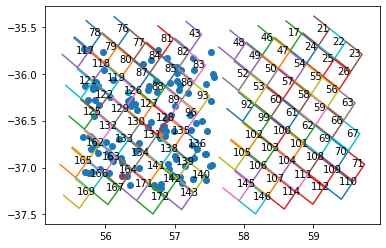

211484 69
59866.324251224534 [59866.323904 59866.324368]
59866.324251224534 1117
87 in this visit in 3828
Scanning 69 images:
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 1 out of 7 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass   delta_flux
18494724  MS_9812_82     211484  59866.323904        i  1027.960938
Matched 0 out of 5 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass  delta_flux
19642989  MS_9812_696     211484  59866.323904        i  2862.79126
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in 

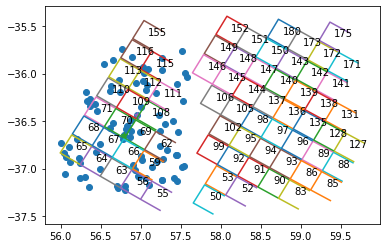

263453 27
59946.186031224526 [59946.185684 59946.186133]
59946.186031224526 1137
75 in this visit in 3828
Scanning 27 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 2 out of 4 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18494771   MS_9812_82     263453  59946.185684        i  1858.850952
18545013  MS_9812_111     263453  59946.185684        i  5056.401367
Matched 1 out of 3 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
29100682  MS_9684_258     263453  59946.185684        i  4727.285156
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 

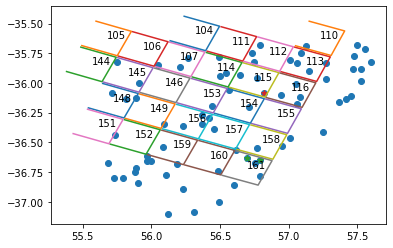

211100 36
59866.14391722222 [59866.14357  59866.144018]
59866.14391722222 1081
24 in this visit in 3828
Scanning 36 images:
Matched 0 out of 5 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image


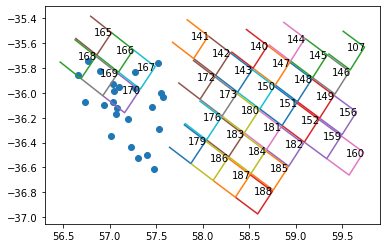

263455 9
59946.18693222222 [59946.186585 59946.187033]
59946.18693222222 1115
22 in this visit in 3828
Scanning 9 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image


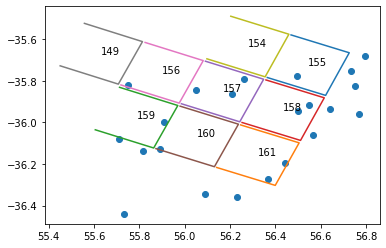

471963 24
60269.07791522106 [60269.077568 60269.078017]
60269.07791522106 1170
62 in this visit in 3828
Scanning 24 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
23758961  MS_9812_2998     471963  60269.077568        i  1493.427246
Matched 1 out of 3 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
21397834  MS_9812_1641     471963  60269.077568        i  1558.627563
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 1 out of 4 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
20565284  MS_9812_1202     471963  60269.077568        i  1384.932739
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe i

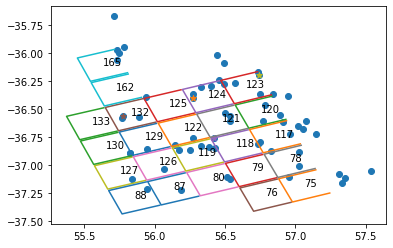

263452 15
59946.18558222222 [59946.185235 59946.185684]
59946.18558222222 1101
82 in this visit in 3828
Scanning 15 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image


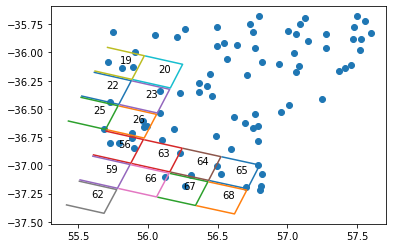

211490 72
59866.327077222224 [59866.32673]
59866.327077222224 533
114 in this visit in 3828
Scanning 72 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 7 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 1 out of 4 SNe in image
Points matched:
                  id  obsHistID         

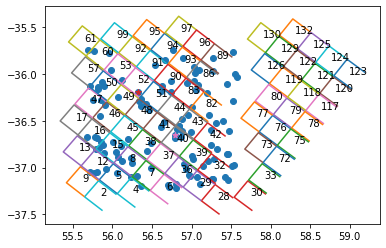

214434 81
59870.20558422338 [59870.205237 59870.205695]
59870.20558422338 658
110 in this visit in 3828
Scanning 81 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 6 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass   delta_flux
18494734  MS_9812_82     214434  59870.205237        i  3547.042725
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
22240764  MS_9812_2080     214434  59870.205237        i  1399

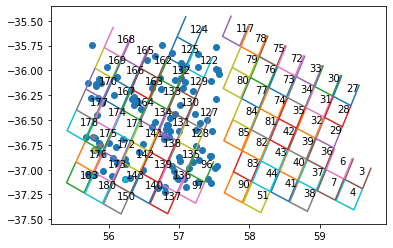

204706 35
59857.34752821991 [59857.347181 59857.347637]
59857.34752821991 1092
102 in this visit in 3828
Scanning 35 images:
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18536579  MS_9812_104     204706  59857.347181        i  8301.820312
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 1 out of 4 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
43636834  MS_9683_1933     204706  59857.347181        i  2240.558105
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 5 SNe in image
Points matched:
                   id  obsHistID     

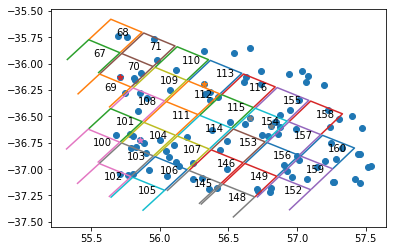

244004 11
59916.18786222222 [59916.187515 59916.18798 ]
59916.18786222222 1078
76 in this visit in 3828
Scanning 11 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 6 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image


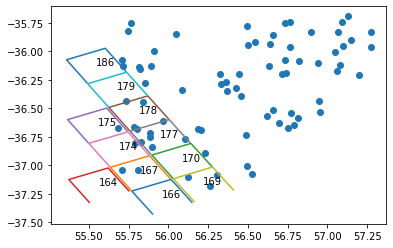

244005 24
59916.18832722222 [59916.18798]
59916.18832722222 556
71 in this visit in 3828
Scanning 24 images:
Matched 0 out of 1 SNe in image
Matched 1 out of 6 SNe in image
Points matched:
                   id  obsHistID          MJD bandpass  delta_flux
19907086  MS_9812_846     244005  59916.18798        i  236.465027
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 7 SNe in image
Points matched:
                   id  obsHistID          MJD bandpass  delta_flux
18536628  MS_9812_104     244005  59916.18798        i  2566.44458
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 5 SNe in image


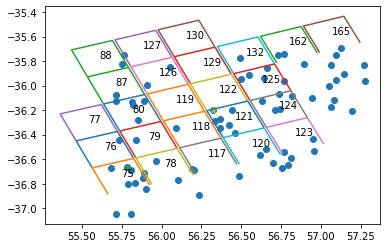

204708 64
59857.34844122454 [59857.348094 59857.348557]
59857.34844122454 1093
74 in this visit in 3828
Scanning 64 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 3 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
28828287  MS_9684_100     204708  59857.348094        i  1699.459717
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 4 SNe in image
Matched 1 out of 5 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
29357977  MS_9684_410     204708  59857.348094        i  4462.605957
Matched 0 out of 1 SNe in image


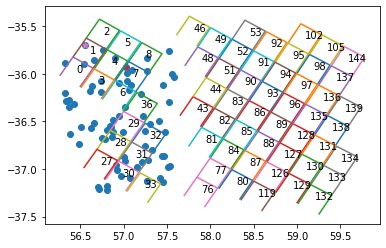

433960 34
60201.24349522106 [60201.243148 60201.243597]
60201.24349522106 1083
75 in this visit in 3828
Scanning 34 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                 id  obsHistID           MJD bandpass   delta_flux
36843  MS_9683_2022     433960  60201.243148        i  1991.441528
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
20052451  MS_9812_921     433960  60201.243148        i  1440.390259
Matched 2 out of 4 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
28870813   MS_9684_125     433960  60201.243148        i  4379.615234
32734618  MS_9684_2348     433960  60201.243148        i  1458.879761
Matched 1 out of 3 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
29250025  MS_9684_341     433960  60201.243148        i  3949.229248


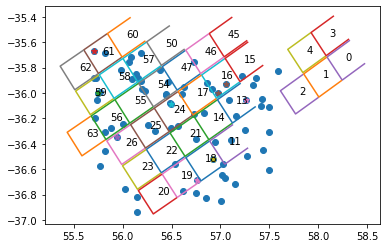

214433 49
59870.20513522106 [59870.204788 59870.205237]
59870.20513522106 1077
110 in this visit in 3828
Scanning 49 images:
Matched 0 out of 2 SNe in image


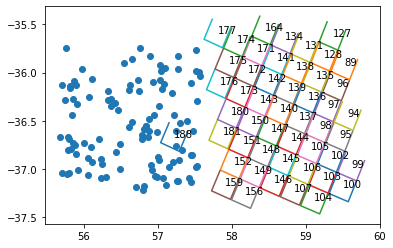

433962 15
60201.244390221065 [60201.244043 60201.244492]
60201.244390221065 1053
40 in this visit in 3828
Scanning 15 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
30637372  MS_9684_1171     433962  60201.244043        i  1297.872925
Matched 1 out of 4 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
42889975  MS_9683_1566     433962  60201.244043        i  1380.479492
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 6 SNe in image
Points matched:
                    id  obsHistID           MJD bandpass   delta_flux
21433717  MS_9812_1660     433962  60201.244043        i  1629.409668
Matched 1 out of 2 SNe in image
Points matched:
      

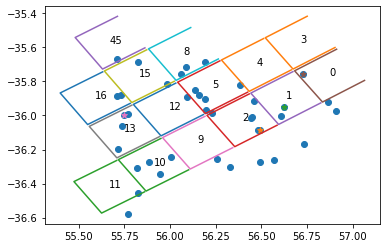

421682 9
60180.324685221065 [60180.324338 60180.324787]
60180.324685221065 821
16 in this visit in 3828
Scanning 9 images:
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
19296780  MS_9812_504     421682  60180.324338        i  2764.185547
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image


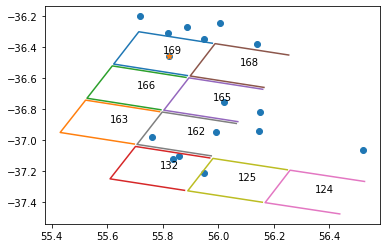

In [205]:
i_visit_points, i_detected_points = find_detected_points(iVisits, 'i')

In [206]:
allI_visit_points = pd.concat(i_visit_points)
allI_detected_points = np.concatenate(i_detected_points)
print(len(allI_visit_points), len(allI_detected_points))

1330 1330


### Which points are detected?

Text(0.5, 0, 'delta_flux')

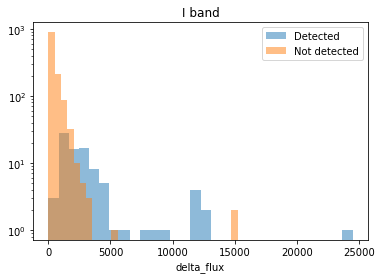

In [209]:
plt.hist(allI_visit_points['delta_flux'][allI_detected_points], alpha=0.5, bins=30, log=True, label='Detected');
plt.hist(allI_visit_points['delta_flux'][~allI_detected_points], alpha=0.5, bins=30, log=True, label='Not detected');
plt.legend()
plt.title('I band')
plt.xlabel('delta_flux')

## Z band:

In [189]:
diaSrcsZ = list(set(butler.registry.queryDatasets('goodSeeingDiff_diaSrc', dataId={"band": "z", "skymap": 'DC2', "tract": 3828})))
print(f"found {len(diaSrcsZ)} diaSrcs in HSC-Z")
zVisits = list(set(diaSrcZ.dataId['visit'] for diaSrcZ in diaSrcsZ))
print(len(zVisits))
print(zVisits)

found 674 diaSrcs in HSC-Z
36
[209031, 474890, 187533, 427030, 187556, 209061, 209062, 226983, 32680, 209063, 209068, 426672, 209843, 460088, 7997, 427069, 7998, 8003, 303559, 243019, 243021, 462543, 240852, 227030, 426969, 8029, 474849, 460130, 460131, 265317, 209018, 13288, 408941, 187502, 209015, 462714]


209031 18
59862.33862222222 [59862.338275 59862.338729]
59862.33862222222 1109
42 in this visit in 3828
Scanning 18 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18536588  MS_9812_104     209031  59862.338275        z  7821.566895
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image


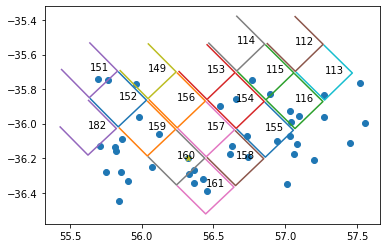

474890 8
60273.07145722222 [60273.07111  60273.071559]
60273.07145722222 890
18 in this visit in 3828
Scanning 8 images:
Matched 0 out of 2 SNe in image
Matched 1 out of 3 SNe in image
Points matched:
                   id  obsHistID          MJD bandpass   delta_flux
40690132  MS_9683_449     474890  60273.07111        z  4749.880859
Matched 0 out of 5 SNe in image


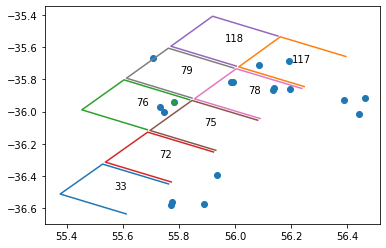

187533 2
59827.28206321991 [59827.281716 59827.28217 ]
59827.28206321991 1026
15 in this visit in 3828
Scanning 2 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image


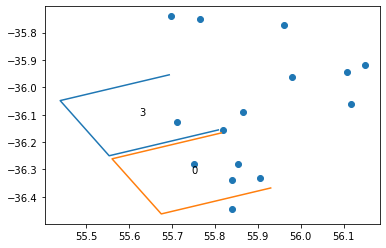

427030 6
60187.325606224535 [60187.325259 60187.325707]
60187.325606224535 1156
24 in this visit in 3828
Scanning 6 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 6 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 2 SNe in image


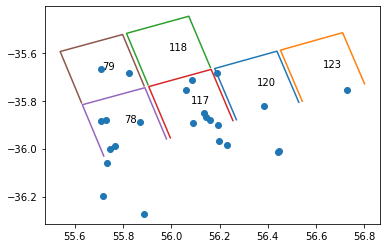

187556 2
59827.29269722222 [59827.29235]
59827.29269722222 540
16 in this visit in 3828
Scanning 2 images:
Matched 0 out of 3 SNe in image


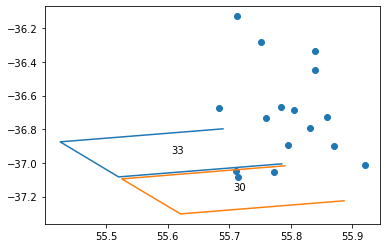

209061 6
59862.354204223375 [59862.353857 59862.354308]
59862.354204223375 1039
45 in this visit in 3828
Scanning 6 images:
Matched 0 out of 4 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image


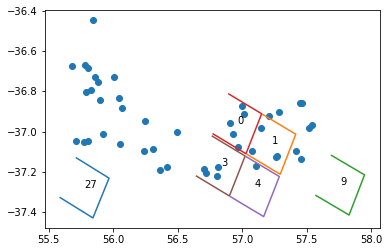

209062 2
59862.35465522106 [59862.354308 59862.354765]
59862.35465522106 1042
105 in this visit in 3828
Scanning 2 images:
Matched 0 out of 2 SNe in image


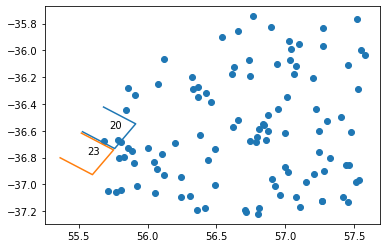

226983 45
59886.11295222222 [59886.112605 59886.113061]
59886.11295222222 1127
107 in this visit in 3828
Scanning 45 images:
Matched 0 out of 2 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass   delta_flux
18494740  MS_9812_82     226983  59886.112605        z  8490.120117
Matched 0 out of 1 SNe in image
Matched 0 out of 7 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 6 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 

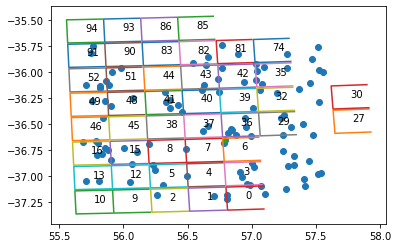

32680 27
59624.042629223375 [59624.042282 59624.042749]
59624.042629223375 680
61 in this visit in 3828
Scanning 27 images:
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image


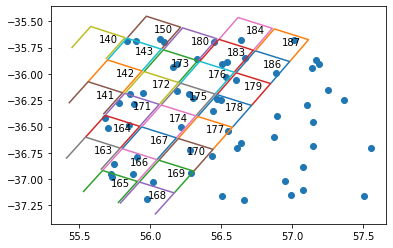

209063 81
59862.35511222221 [59862.354765 59862.355221]
59862.35511222221 1063
105 in this visit in 3828
Scanning 81 images:
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 6 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 6 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 1 out of 4 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass    delta_flux
18387556  MS_9812_17  

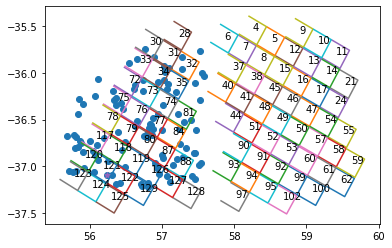

209068 70
59862.35756122453 [59862.357214 59862.357662]
59862.35756122453 1035
114 in this visit in 3828
Scanning 70 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 7 SNe in image
Matched 1 out of 9 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass  delta_flux
18494720  MS_9812_82     209068  59862.357214        z  103.060081
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 2 SNe in image
Points matched:
     

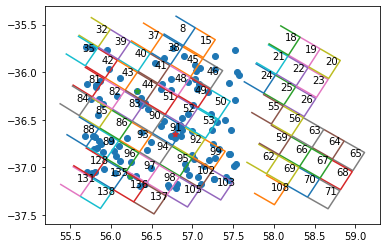

426672 47
60185.38206821991 [60185.381721 60185.382201]
60185.38206821991 1128
104 in this visit in 3828
Scanning 47 images:
Matched 0 out of 6 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 3 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass  delta_flux
28870803  MS_9684_125     426672  60185.381721        z  5156.54248
Matched 1 out of 4 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18980908  MS_9812_339     426672  60185.381721        z  5066.837891
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in

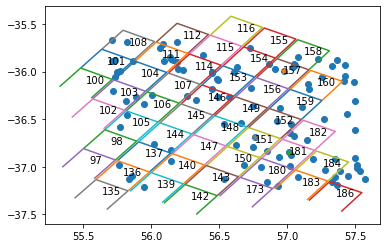

209843 16
59863.33140522106 [59863.331058 59863.331515]
59863.33140522106 555
45 in this visit in 3828
Scanning 16 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 6 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image


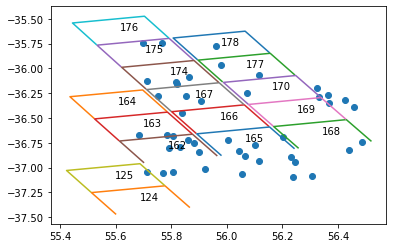

460088 3
60244.22601122454 [60244.225664 60244.226409]
60244.22601122454 816
6 in this visit in 3828
Scanning 3 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image


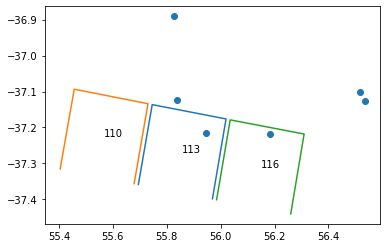

7997 72
59591.08087422338 [59591.080527 59591.081006]
59591.08087422338 385
34 in this visit in 3828
Scanning 72 images:
Matched 0 out of 2 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass    delta_flux
28714347  MS_9684_32       7997  59591.080527        z  10277.668945
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image


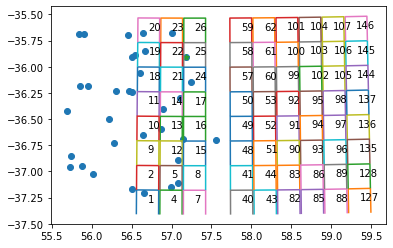

427069 12
60187.34497622454 [60187.344629 60187.345078]
60187.34497622454 1005
35 in this visit in 3828
Scanning 12 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image


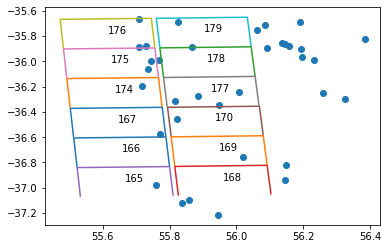

7998 40
59591.08135321991 [59591.081006 59591.081463]
59591.08135321991 422
31 in this visit in 3828
Scanning 40 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18779743  MS_9812_231       7998  59591.081006        z  5365.583496
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image


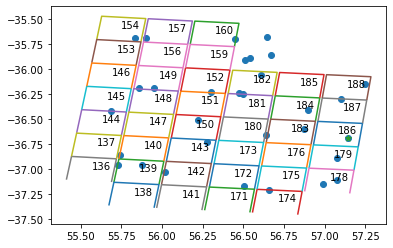

8003 42
59591.08405922337 [59591.083712 59591.084162]
59591.08405922337 391
26 in this visit in 3828
Scanning 42 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                  id  obsHistID           MJD bandpass    delta_flux
28714348  MS_9684_32       8003  59591.083712        z  10280.007812
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image


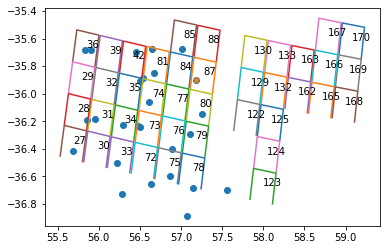

303559 37
60005.038777222224 [60005.03843  60005.038879]
60005.038777222224 1113
107 in this visit in 3828
Scanning 37 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 9 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 6 SNe in image
Matched 1 out of 4 SNe in image
Points matched:
                   id  obsHistID          MJD bandpass  delta_flux
19261243  MS_9812_484     303559  60005.03843        z  3095.51123
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 

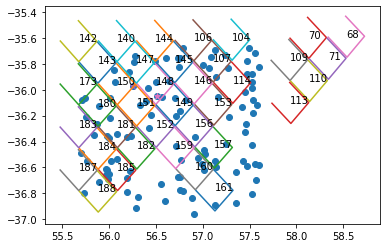

243019 68
59915.05746821991 [59915.057121 59915.057573]
59915.05746821991 1098
88 in this visit in 3828
Scanning 68 images:
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 4 SNe in image
Points matched:
                id  obsHistID           MJD bandpass  delta_flux
110879  hl_ms_4158     243019  59915.057121        z  3036.68457
Matched 0 out of 6 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image


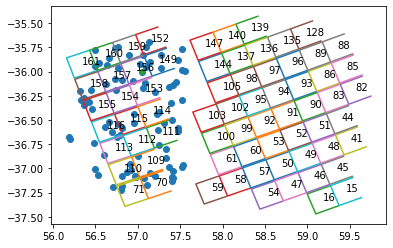

243021 10
59915.058410221056 [59915.058063 59915.058512]
59915.058410221056 1059
28 in this visit in 3828
Scanning 10 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 4 SNe in image


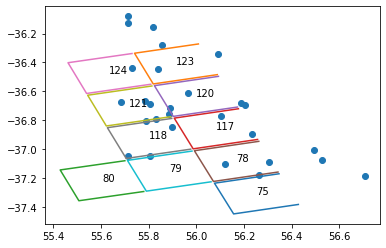

462543 3
60247.23058622453 [60247.230239 60247.230689]
60247.23058622453 1139
7 in this visit in 3828
Scanning 3 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image


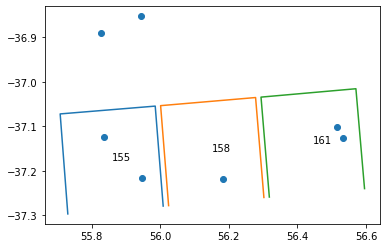

240852 42
59912.058287222215 [59912.05794  59912.058398]
59912.058287222215 1046
106 in this visit in 3828
Scanning 42 images:
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 5 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 1 out of 8 SNe in image
Points matched:
                  id  obsHistID          MJD bandpass   delta_flux
18494753  MS_9812_82  

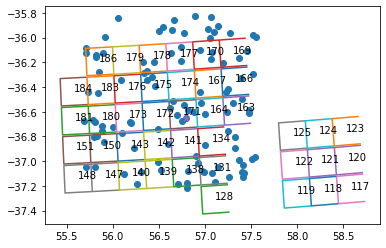

227030 2
59886.13663422338 [59886.136287 59886.136741]
59886.13663422338 1162
2 in this visit in 3828
Scanning 2 images:


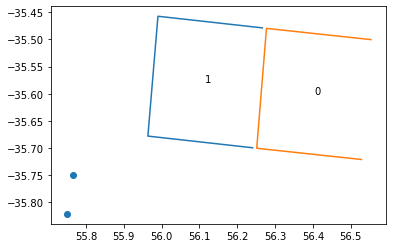

426969 1
60187.29620122454 [60187.295854 60187.296303]
60187.29620122454 1172
10 in this visit in 3828
Scanning 1 images:
Matched 0 out of 1 SNe in image


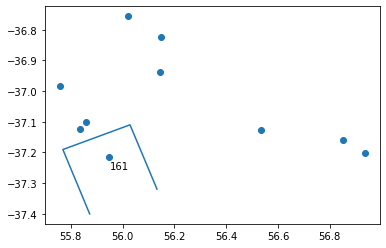

8029 46
59591.09666122454 [59591.096314 59591.096764]
59591.09666122454 392
29 in this visit in 3828
Scanning 46 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 3 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 1 out of 1 SNe in image
Points matched:
                   id  obsHistID           MJD bandpass   delta_flux
18779745  MS_9812_231       8029  59591.096314        z  5366.952148
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image


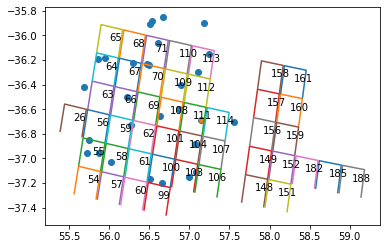

474849 1
60273.05214922338 [60273.051802 60273.052249]
60273.05214922338 1165
4 in this visit in 3828
Scanning 1 images:
Matched 0 out of 1 SNe in image


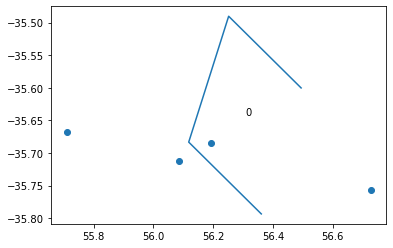

460130 18
60244.24619422338 [60244.245847 60244.24631 ]
60244.24619422338 1151
41 in this visit in 3828
Scanning 18 images:
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 2 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 4 SNe in image
Matched 0 out of 1 SNe in image


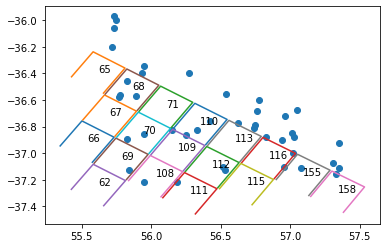

460131 4
60244.24665722222 [60244.24631  60244.246767]
60244.24665722222 1090
14 in this visit in 3828
Scanning 4 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 3 SNe in image


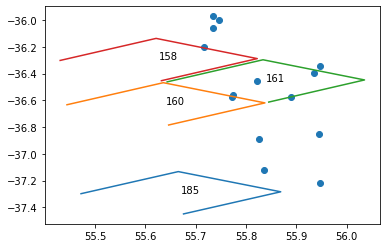

265317 4
59949.07510022106 [59949.074753]
59949.07510022106 572
10 in this visit in 3828
Scanning 4 images:
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image
Matched 0 out of 1 SNe in image


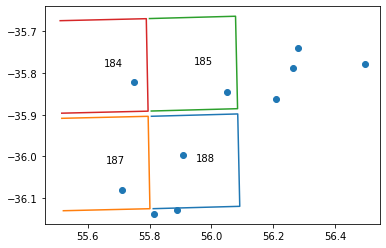

In [201]:
z_visit_points, z_detected_points = find_detected_points(zVisits, 'z')

In [202]:
allZ_visit_points = pd.concat(z_visit_points)
allZ_detected_points = np.concatenate(z_detected_points)
print(len(allZ_visit_points), len(allZ_detected_points))

843 843


### Which points are detected?

Text(0.5, 0, 'delta_flux')

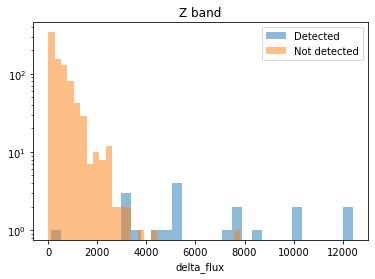

In [211]:
plt.hist(allZ_visit_points['delta_flux'][allZ_detected_points], alpha=0.5, bins=30, log=True, label='Detected');
plt.hist(allZ_visit_points['delta_flux'][~allZ_detected_points], alpha=0.5, bins=30, log=True, label='Not detected');
plt.legend()
plt.title('Z band')
plt.xlabel('delta_flux')

# Which SNe are detected in the `assocDiaSrcTables`?

In [13]:
sn_patches = np.array([tractInfo.findPatch(lsst.geom.SpherePoint(sn['ra'], sn['dec'], lsst.geom.degrees)) for s, sn in sn_in3828.iterrows()])

In [14]:
minMJD = 59582.
maxMJD = 60310.
brightSN_points = snTruth_lcs[(snTruth_lcs['delta_flux'] > 1500) & (snTruth_lcs['MJD'] > minMJD)
                              & (snTruth_lcs['MJD'] < maxMJD)]
brightSN_ids = pd.unique(brightSN_points['id'])

membership = sn_in3828['id'].isin(brightSN_ids)
brightSN = sn_in3828[membership]
bright_patches = sn_patches[membership]

In [15]:
SN_points_r = snTruth_lcs[(snTruth_lcs['MJD'] > minMJD) & (snTruth_lcs['bandpass'] == 'r')
                              & (snTruth_lcs['MJD'] < maxMJD)]
SN_points_i = snTruth_lcs[(snTruth_lcs['MJD'] > minMJD) & (snTruth_lcs['bandpass'] == 'i')
                              & (snTruth_lcs['MJD'] < maxMJD)]
SN_points_z = snTruth_lcs[(snTruth_lcs['MJD'] > minMJD) & (snTruth_lcs['bandpass'] == 'z')
                              & (snTruth_lcs['MJD'] < maxMJD)]

Patch 19
There are 62 sne are in the truth catalog, of which 1 are bright (flux > 1500 in any band)
5 found in assocDiaSrcTable

Patch 26
There are 50 sne are in the truth catalog, of which 2 are bright (flux > 1500 in any band)
2 found in assocDiaSrcTable

Patch 32
There are 56 sne are in the truth catalog, of which 6 are bright (flux > 1500 in any band)
4 found in assocDiaSrcTable

Patch 40
There are 58 sne are in the truth catalog, of which 2 are bright (flux > 1500 in any band)
6 found in assocDiaSrcTable

Patch 33
There are 57 sne are in the truth catalog, of which 0 are bright (flux > 1500 in any band)
4 found in assocDiaSrcTable

Patch 39
There are 70 sne are in the truth catalog, of which 2 are bright (flux > 1500 in any band)
3 found in assocDiaSrcTable

Total: 353
Bright: 13
Found: 24


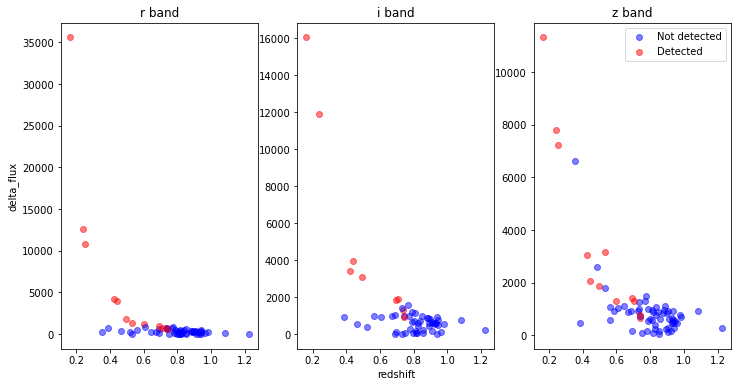

In [16]:
assocDiaSrcTableRefs = list(butler.registry.queryDatasets("goodSeeingDiff_assocDiaSrcTable"))
total_sne = 0
bright_count = 0
found_sne = 0
fig, subs = plt.subplots(1, 3, sharex=True, figsize=(12, 6))
for i, assocRef in enumerate(assocDiaSrcTableRefs):
    patch = assocRef.dataId['patch']
    print("Patch", patch)
    patchInd = tractInfo[patch].getIndex()
    sne = sn_in3828[np.array([sn_patch.getIndex() == patchInd for sn_patch in sn_patches])].reset_index()
    sn_maxes = np.zeros((len(sne), 3))
    for s, sn in sne.iterrows():
        match_r = SN_points_r[SN_points_r['id'] == sn['id']]
        match_i = SN_points_i[SN_points_i['id'] == sn['id']]
        match_z = SN_points_z[SN_points_z['id'] == sn['id']]
        sn_maxes[s, 0] = match_r['delta_flux'].max()
        sn_maxes[s, 1] = match_i['delta_flux'].max()
        sn_maxes[s, 2] = match_z['delta_flux'].max()

    bright_sne = np.array([sn_patch.getIndex() == patchInd for sn_patch in bright_patches])
    bright_count += bright_sne.sum()
    truth_cat = SkyCoord(ra=sne['ra'], dec=sne['dec'], unit=u.degree)
    print(f'There are {len(sne)} sne are in the truth catalog, of which {bright_sne.sum()} are bright (flux > 1500 in any band)')
    total_sne += len(sne)
    assocObjTable = butler.get(assocRef)
    assocObj_cat = SkyCoord(ra=assocObjTable['ra'], dec=assocObjTable['decl'], unit=u.degree)
    idx, d2d, d3d = truth_cat.match_to_catalog_sky(assocObj_cat)
    found = (d2d.arcsecond < 0.5).sum()
    for s in range(3):
        subs[s].scatter(sne['redshift'][d2d.arcsecond >= 0.5], sn_maxes[d2d.arcsecond >= 0.5, s], color='blue', alpha=0.5, label=('Not detected' if i == 0 else None))
        subs[s].scatter(sne['redshift'][d2d.arcsecond < 0.5], sn_maxes[d2d.arcsecond < 0.5, s], color='red', alpha=0.5, label=('Detected' if i == 0 else None))
    print(found, 'found in assocDiaSrcTable\n')
    found_sne += found
subs[0].set_title('r band')
subs[1].set_title('i band')
subs[2].set_title('z band')
subs[1].set_xlabel('redshift')
subs[0].set_ylabel('delta_flux')
plt.legend()
print('Total:', total_sne)
print("Bright:", bright_count)
print('Found:', found_sne)

# What do the SN points look like in the calexps and difference images?

In [19]:
calexps = set(butler.registry.queryDatasets('calexp', dataId={"band": "r", "skymap": 'DC2', "tract": 3828, "patch": 19}))
print(f"found {len(calexps)} calexps")
calexps_full = [butler.get('calexp', dataId=calDataId.dataId) for calDataId in list(calexps)]

found 116 calexps


In [20]:
dates = [calexp.getInfo().getVisitInfo().getDate() for calexp in calexps_full]
mjds = [date.get(date.MJD) for date in dates]

In [35]:
mjds = np.array(mjds)

In [23]:
calexp_vis = np.array([calexp.dataId['visit'] for calexp in calexps])
calexp_ccd = np.array([calexp.dataId['detector'] for calexp in calexps])

In [32]:
diffs = [butler.get('goodSeeingDiff_differenceExp', dataId=calRef.dataId) for calRef in list(calexps)]

In [38]:
dia_srcs = np.array([butler.get('goodSeeingDiff_diaSrc', dataId=calexp.dataId) for calexp in calexps])

<ipython-input-38-f646da3e4aa2>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  dia_srcs = np.array([butler.get('goodSeeingDiff_diaSrc', dataId=calexp.dataId) for calexp in calexps])


In [43]:
assocDiaSrcs = butler.get('goodSeeingDiff_assocDiaSrcTable', dataId={"skymap": 'DC2', "tract": 3828, "patch": 19})

In [25]:
def boxContains(box, point2d):
    newPoint = lsst.geom.Point2I(int(point2d.x), int(point2d.y))
    return box.contains(newPoint)

In [41]:
def makeCutout(detection, expF, ext=30):
    cutoutSize = lsst.geom.Extent2I(ext, ext)
    try:
        cutoutCenter = lsst.geom.SpherePoint(detection['ra'], detection['decl'], lsst.geom.degrees)
    except:
        cutoutCenter = lsst.geom.SpherePoint(detection['ra'], detection['dec'], lsst.geom.degrees)
        cutout = expF.getCutout(cutoutCenter, cutoutSize)
    return cutout

In [27]:
bboxes = [cal.getBBox() for cal in calexps_full]
wcss = [cal.getWcs() for cal in calexps_full]

In [30]:
invis_tots = []
patch_sne = []
patch_sne_visits = []
for s, sn in sn_in3828.iterrows():
    sp = lsst.geom.SpherePoint(sn['ra'], sn['dec'], lsst.geom.degrees)
    #if not boxContains(patchBBox, tractWcs.skyToPixel(sp)):
    #    continue
    #print(s)
    inVisits = np.array([boxContains(bboxes[j], wcss[j].skyToPixel(sp)) for j in range(len(calexp_vis))])
    invis_tots.append(inVisits.sum())
    if inVisits.sum() > 0:
        patch_sne.append(sn)
        patch_sne_visits.append(inVisits)
print(len(patch_sne), 'test sne')

602 test sne


In [36]:
foundSN = 0
match_sne = []
match_sne_idx = []
for s, testSN in enumerate(patch_sne):
    testSN_visits = patch_sne_visits[s]

    match_calexps = np.array(calexps_full)[testSN_visits]
    match_diffs = np.array(diffs)[testSN_visits]
    match_visits = calexp_vis[testSN_visits]
    match_mjds = mjds[testSN_visits]

    testLC = snTruth_lcs[snTruth_lcs['id'] == testSN['id']]
    testLC_r = testLC[testLC['bandpass'] == 'r'].reset_index()
    
    close_mjds = np.zeros(len(testLC_r))
    for i, obs in testLC_r.iterrows():
        best_match = min(abs(match_mjds - obs['MJD']))
        close_mjds[i] = best_match
    if (close_mjds < 1).sum() > 0:
        match_sne.append(testSN)
        match_sne_idx.append(s)
        print(f'\nSN', s, testSN['id'])
        print(f'SN is in {len(match_calexps)} calexps')
        print(f'SN true lc has {len(testLC)} points, of which {len(testLC_r)} are in r-band')
        print("match mjds:", match_mjds[match_mjds.argsort()])
        print("lc mjds:", np.array(testLC_r['MJD']))
        print(close_mjds)
        print(f'Close mjd matches: {(close_mjds < .1).sum()}')
        print('Flux max:', testLC_r['delta_flux'].max())
        foundSN += 1
    if foundSN == 15:
        break


SN 26 MS_9812_207
SN is in 19 calexps
SN true lc has 72 points, of which 16 are in r-band
match mjds: [59798.31556222 59839.37482122 59840.26664022 59854.27827222
 59854.29414122 59854.29956022 59867.21492422 59867.23940622
 59869.14335222 59929.12424722 59929.14748622 59937.10501522
 59957.15996422 60143.42129422 60147.41623022 60175.29155122
 60206.26214422 60224.16819222 60232.15435322]
lc mjds: [59839.353678 59839.374474 59839.374996 59840.247246 59840.266293
 59849.272671 59854.276567 59854.277925 59854.293794 59854.299213
 59867.214128 59867.214577 59867.239059 59868.128341 59869.143005
 59869.159323]
[2.11432245e-02 3.47224530e-04 1.74775472e-04 1.93942211e-02
 3.47221059e-04 5.00560122e+00 1.70522222e-03 3.47222216e-04
 3.47224544e-04 3.47221066e-04 7.96223379e-04 3.47223380e-04
 3.47224537e-04 8.88934775e-01 3.47222223e-04 1.59707778e-02]
Close mjd matches: 14
Flux max: 4482.7529296875

SN 36 MS_9812_275
SN is in 22 calexps
SN true lc has 14 points, of which 1 are in r-band
m


SN 108 MS_9812_921
SN is in 7 calexps
SN true lc has 68 points, of which 17 are in r-band
match mjds: [59798.31556222 59839.35402522 59839.37482122 59867.23940622
 59929.12424722 59929.14748622 60232.15435322]
lc mjds: [60166.338185 60166.356822 60175.291204 60206.261797 60206.283964
 60206.306756 60211.229726 60211.245379 60224.167845 60232.148124
 60232.154006 60232.294025 60234.140201 60234.157002 60240.130912
 60240.13136  60240.145439]
[6.58161682e+01 6.57975312e+01 5.68631492e+01 2.58925562e+01
 2.58703892e+01 2.58475972e+01 2.09246272e+01 2.09089742e+01
 7.98650822e+00 6.22921991e-03 3.47219910e-04 1.39671780e-01
 1.98584778e+00 2.00264878e+00 7.97655878e+00 7.97700678e+00
 7.99108578e+00]
Close mjd matches: 2
Flux max: 1778.5457763671875


MS_9812_207 55.85885653749325 -36.727059574295915
found diasrc match 1
Subplot 1, flux=4480.1748046875
found diasrc match 1
Subplot 2, flux=4368.224609375
found diasrc match 1
Subplot 3, flux=2143.02685546875
found diasrc match 1
Subplot 4, flux=2140.79248046875
found diasrc match 1
Subplot 5, flux=2140.0302734375
found diasrc match 1
Subplot 6, flux=947.8953247070312
Subplot 7, flux=946.6638793945312
Subplot 8, flux=859.9739379882812
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1


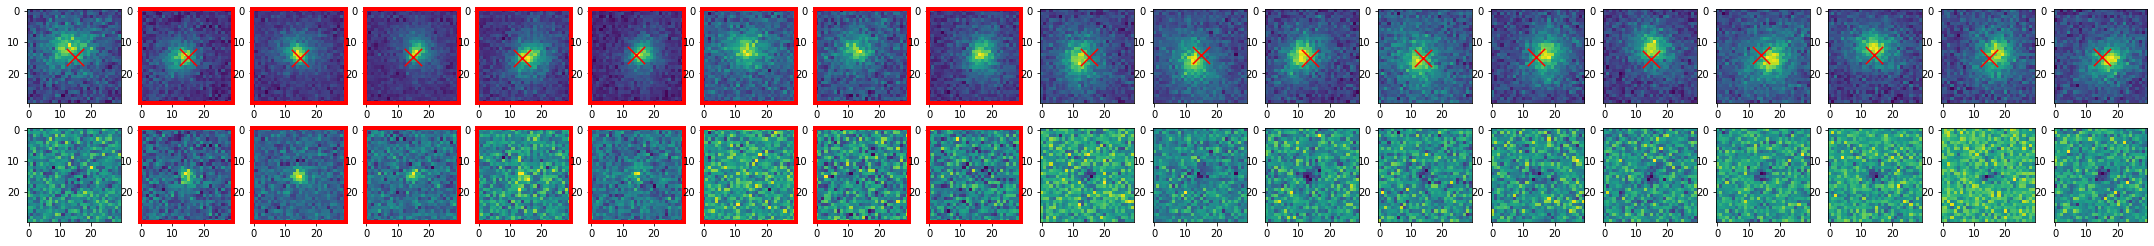

MS_9812_275 56.185409725727354 -36.79358090753147
Subplot 12, flux=3596.271728515625
found diasrc match 1


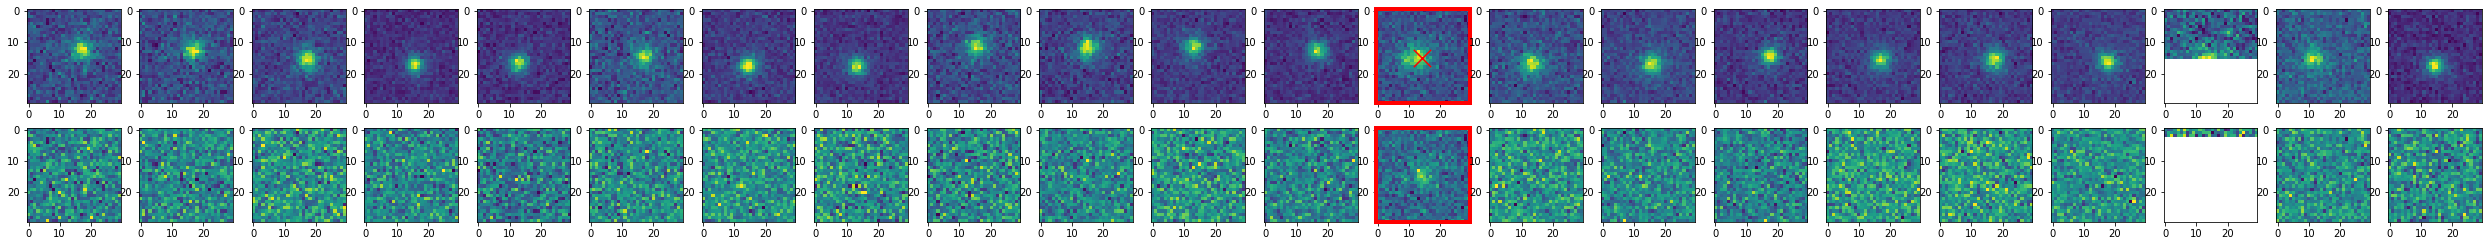

MS_9812_463 55.94471751879772 -36.85264077435543
Subplot 9, flux=3.6380162239074707
Subplot 10, flux=378.6433410644531
Subplot 11, flux=649.495361328125
Subplot 12, flux=1682.4005126953125
found diasrc match 1
Subplot 13, flux=1665.6553955078125
found diasrc match 1


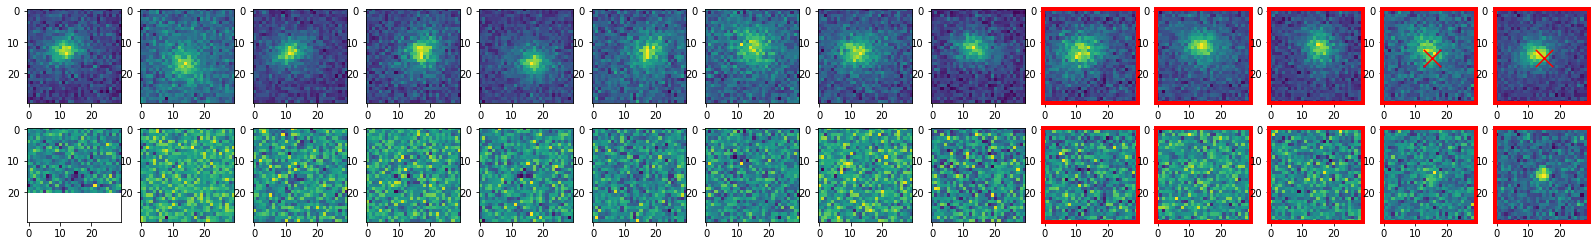

MS_9812_504 55.82212687431419 -36.45676866900526
Subplot 7, flux=441.4059753417969
Subplot 8, flux=193.41265869140625
Subplot 9, flux=173.99737548828125
Subplot 10, flux=155.8777618408203


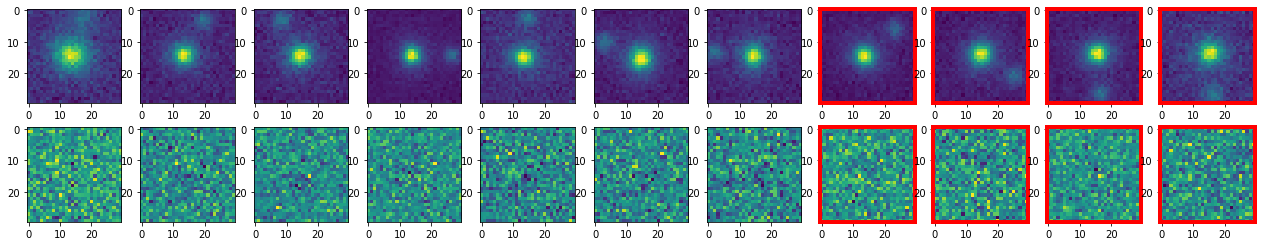

MS_9812_527 55.95662027244872 -36.61688034413638
Subplot 15, flux=206.79368591308594


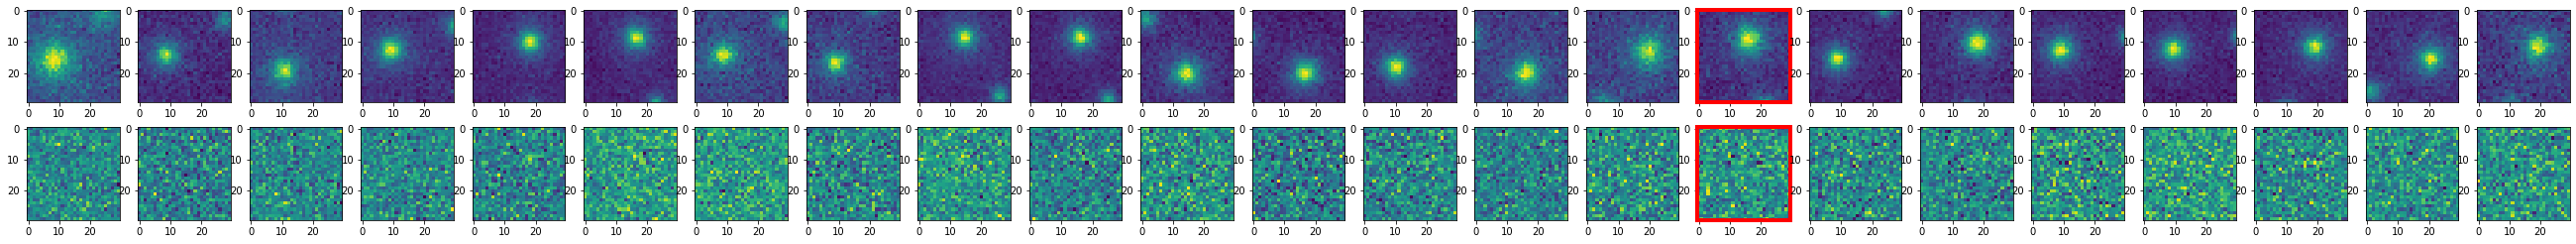

MS_9812_532 56.0449445031928 -36.831249483981615
Subplot 0, flux=415.803466796875
Subplot 1, flux=398.88067626953125
Subplot 2, flux=271.333740234375
Subplot 3, flux=271.27276611328125
Subplot 4, flux=271.2519226074219
Subplot 5, flux=217.2415313720703
Subplot 6, flux=213.63121032714844


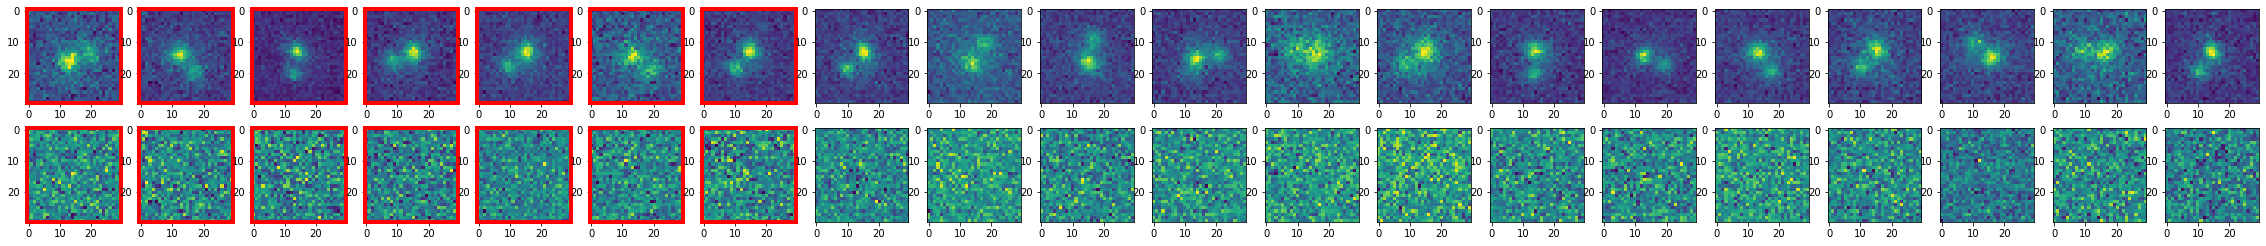

MS_9812_585 56.18849121585878 -36.36502161872774
Subplot 0, flux=362.5895080566406


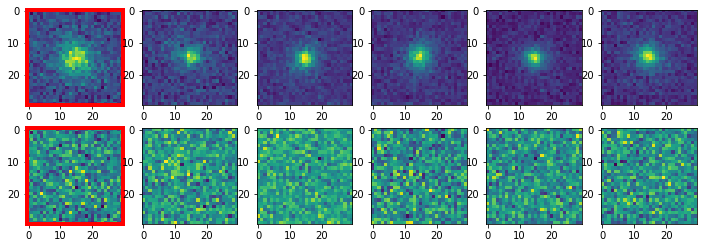

MS_9812_592 55.97073060687159 -36.660415749888564
Subplot 13, flux=577.87646484375


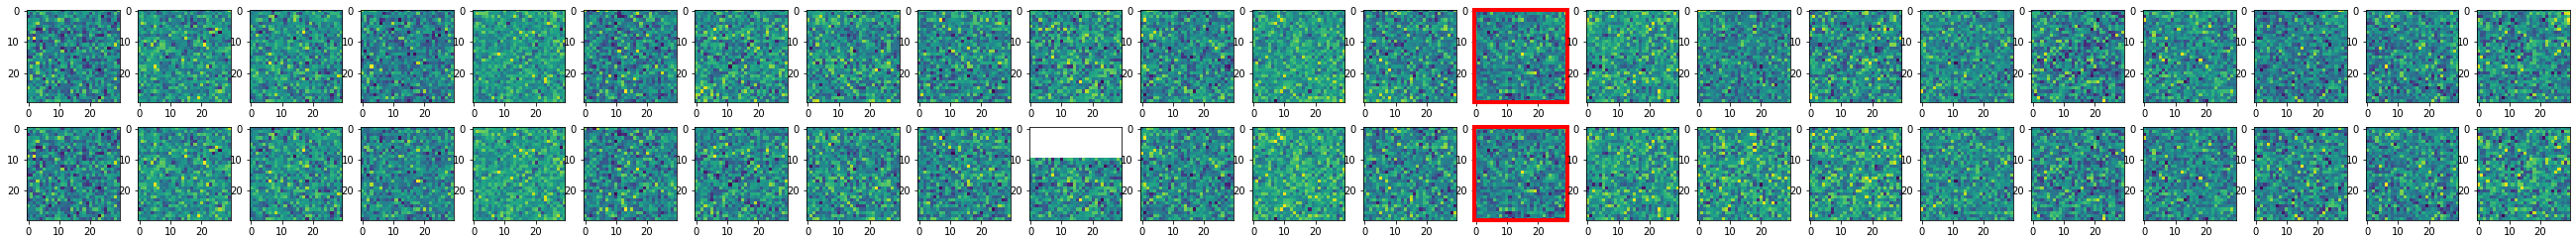

MS_9812_606 55.73148396987286 -36.43993919909422
Subplot 0, flux=3552.29248046875
found diasrc match 1
Subplot 1, flux=801.521728515625


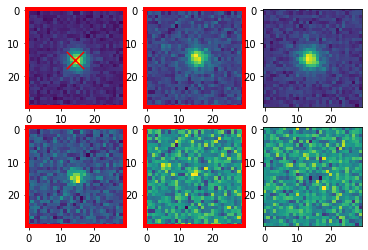

MS_9812_646 56.38315632762208 -36.62968543409655
Subplot 0, flux=115.91093444824219
Subplot 1, flux=115.83729553222656
Subplot 2, flux=112.94310760498047
Subplot 3, flux=90.36320495605469


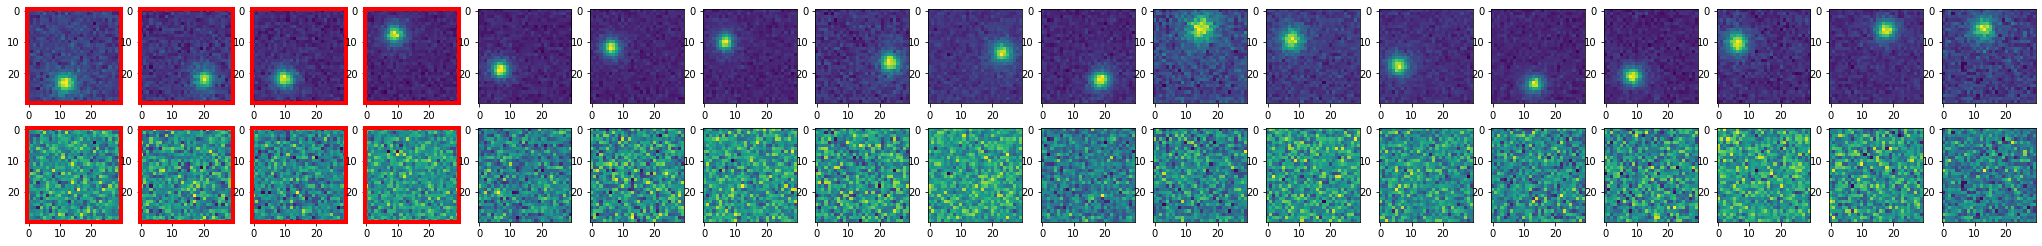

MS_9812_777 56.28199888414245 -36.910558655957466
Subplot 8, flux=1443.259765625
found diasrc match 1


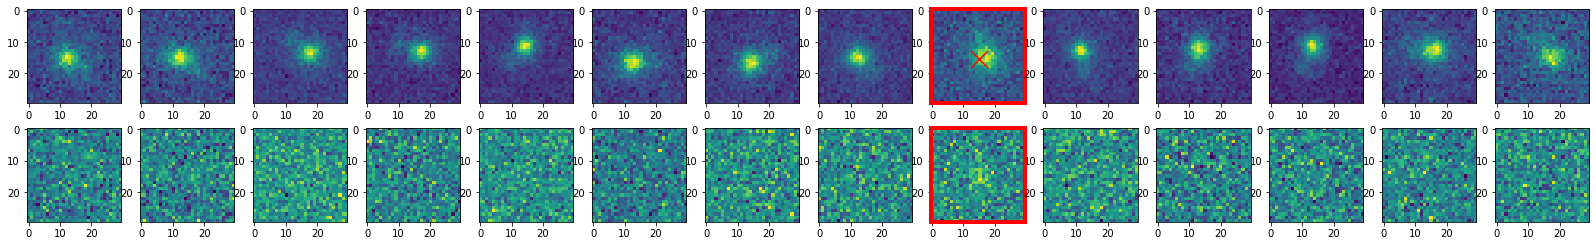

MS_9812_824 56.02341128205755 -36.55090410836127
Subplot 12, flux=18.092065811157227


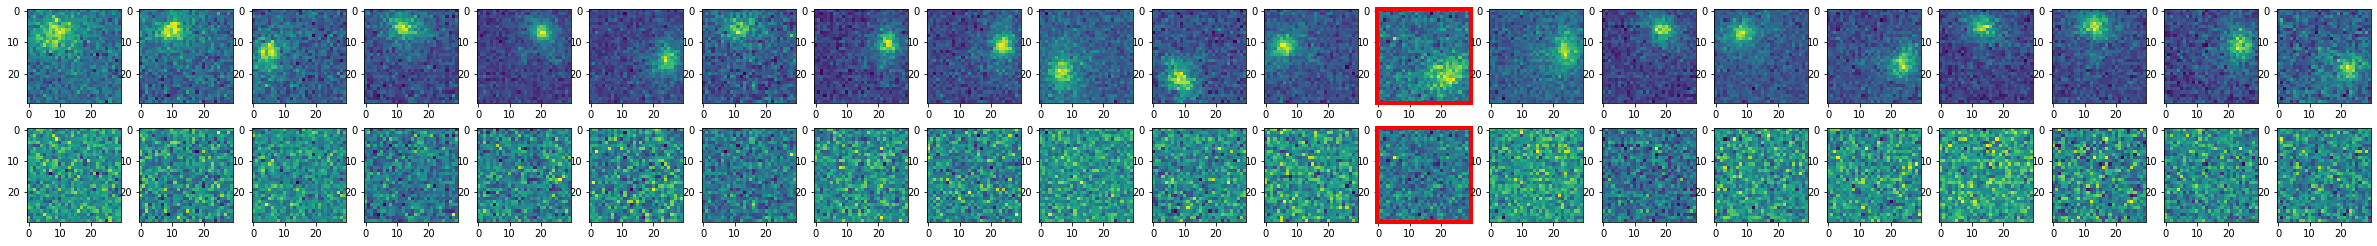

MS_9812_846 55.784483652219244 -36.667583777731956
Subplot 0, flux=683.2391967773438
found diasrc match 1
Subplot 1, flux=811.9584350585938
found diasrc match 1
Subplot 2, flux=2669.202880859375
found diasrc match 1
Subplot 3, flux=2669.90234375
found diasrc match 1
Subplot 4, flux=1795.4149169921875
Subplot 5, flux=1792.890625
Subplot 6, flux=101.60066223144531
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1
found diasrc match 1


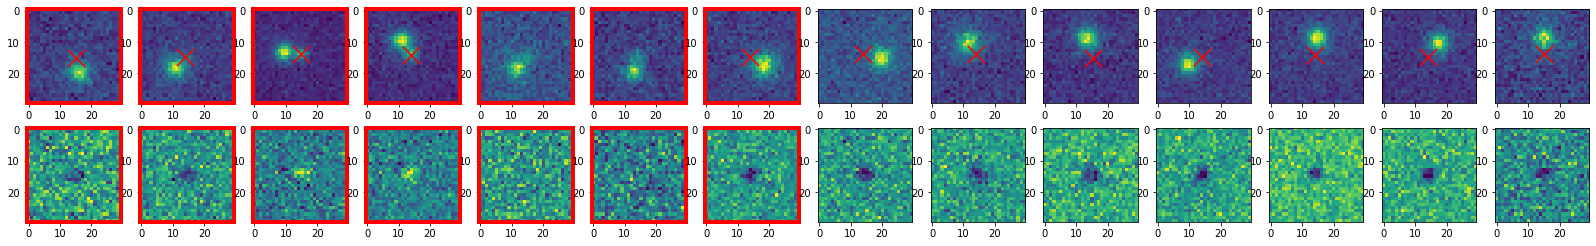

MS_9812_907 56.06515012391178 -36.883082313952265
Subplot 0, flux=1050.7388916015625
found diasrc match 1
Subplot 1, flux=985.2195434570312
found diasrc match 1
Subplot 2, flux=199.02328491210938
Subplot 3, flux=198.86395263671875
Subplot 4, flux=91.34601593017578
Subplot 5, flux=82.70478057861328
Subplot 6, flux=82.6263427734375


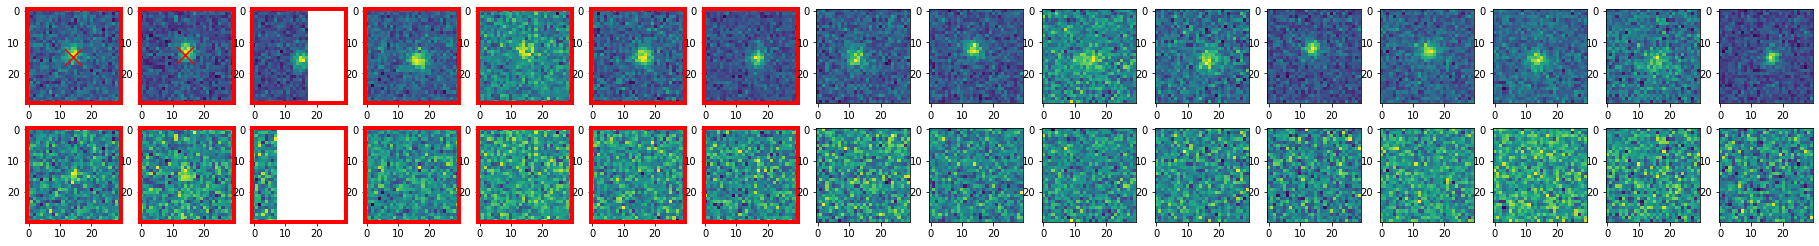

MS_9812_921 55.94726842586046 -36.34474731751715
Subplot 6, flux=131.58779907226562


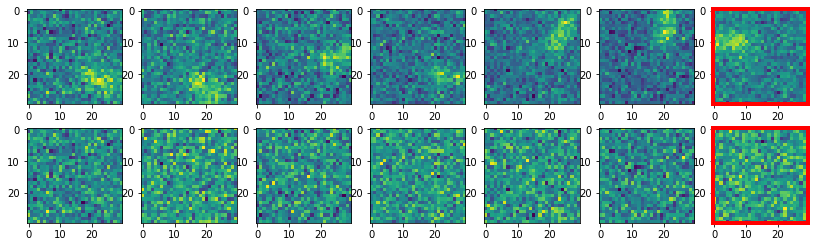

In [44]:
for match_idx, testSN in zip(match_sne_idx, match_sne):
    print(testSN['id'], testSN['ra'], testSN['dec'])
    testSN_visits = patch_sne_visits[match_idx]
    
    match_visits = calexp_vis[testSN_visits]
    match_mjds = mjds[testSN_visits]
    order = match_mjds.argsort()
    match_mjds = match_mjds[order]
    match_calexps = np.array(calexps_full)[testSN_visits][order]
    match_diffs = np.array(diffs)[testSN_visits][order]
    match_dia = dia_srcs[testSN_visits][order]
    
    testLC = snTruth_lcs[snTruth_lcs['id'] == testSN['id']]
    testLC_r = testLC[testLC['bandpass'] == 'r'].reset_index()
    fluxes = np.array(testLC_r['delta_flux'])
    testLC_mjds = testLC_r['MJD']
    
    fig, subs = plt.subplots(2, len(match_calexps), figsize=(2 * len(match_calexps), 4))
    for i, calexp in enumerate(match_calexps):
        calexp_cutout = makeCutout(testSN, calexp)
        cutWcs = calexp_cutout.getWcs()
        subs[0, i].imshow(calexp_cutout.getImage().array)
        if min(abs(testLC_mjds - match_mjds[i])) < 1:
            plt.setp(subs[0,i].spines.values(), color='r', linewidth=4)
            plt.setp(subs[1,i].spines.values(), color='r', linewidth=4)
            print(f'Subplot {i}, flux={fluxes[(abs(testLC_mjds - match_mjds[i])).argmin()]}')
        if match_diffs[i] is not None:
            diff_cutout = makeCutout(testSN, match_diffs[i])
            subs[1, i].imshow(diff_cutout.getImage().array)
        # Get dia sources:
        dia_mjd_matches = assocDiaSrcs[abs(assocDiaSrcs['midPointTai'] - match_mjds[i]) < 0.5]
        ra_dec_matches = dia_mjd_matches[(abs(dia_mjd_matches['ra'] - testSN['ra']) < 0.001) & (abs(dia_mjd_matches['decl'] - testSN['dec']) < 0.001)]
        match_dia_ra = match_dia[i]['coord_ra'] * 180 / np.pi
        match_dia_dec = match_dia[i]['coord_dec'] * 180 / np.pi
        match_dia_matches = match_dia[i][(abs(match_dia_ra - testSN['ra']) < 0.001) & (abs(match_dia_dec - testSN['dec']) < 0.001)]
        if len(ra_dec_matches) > 0:
            print("found assocDiaSrc match", len(match_dia_matches))
        if len(match_dia_matches) > 0:
            print("found diasrc match", len(match_dia_matches))
        for m, match_src in ra_dec_matches.iterrows():
            src_sp = lsst.geom.SpherePoint(match_src['ra'], match_src['decl'], lsst.geom.degrees)
            src_pix = cutWcs.skyToPixel(src_sp)
            minx = calexp_cutout.getBBox().beginX
            miny = calexp_cutout.getBBox().beginY
            subs[0, i].scatter(src_pix[0] - minx, src_pix[1] - miny, marker='+', color='orange', s=300)
        for m, match_src in enumerate(match_dia_matches):
            src_sp = lsst.geom.SpherePoint(match_src['coord_ra'] * 180 / np.pi, match_src['coord_dec'] * 180 / np.pi,
                                           lsst.geom.degrees)
            src_pix = cutWcs.skyToPixel(src_sp)
            minx = calexp_cutout.getBBox().beginX
            miny = calexp_cutout.getBBox().beginY
            subs[0, i].scatter(src_pix[0] - minx, src_pix[1] - miny, marker='x', color='r', s=300)
    plt.show()